C:\Users\Acer\AppData\Local\Temp\ipykernel_22948\1816052960.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model.load_state_dict(torch.load(model_path, map_loca

ValueError: The number of FixedLocator locations (15), usually from a call to set_ticks, does not match the number of labels (14).

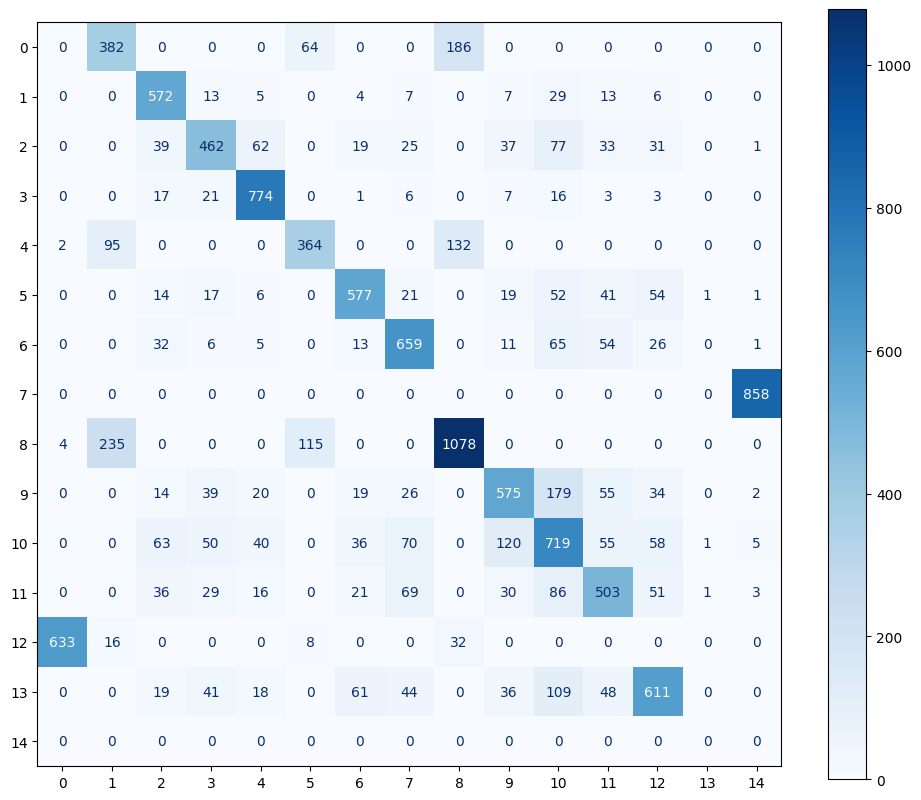

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import numpy as np

# Define a custom ResNet model with added dropout and a fully connected layer
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)  # Load pre-trained ResNet101 model
        self.model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.model.fc.in_features, num_classes),
        )

    def forward(self, x):
        return self.model(x)

# Function to plot metrics for 13 classes
def plot_metrics_multiclass(all_labels, all_preds, num_classes, class_names):
    """
    Plots Confusion Matrix, ROC Curves, and Precision-Recall Curves for multiclass classification.

    Parameters:
    - all_labels: Ground-truth labels (1D array).
    - all_preds: Model predictions (logits or probabilities).
    - num_classes: Number of classes.
    - class_names: List of class names.
    """
    # Convert logits to probabilities
    all_preds_probs = torch.softmax(torch.tensor(all_preds), dim=1).numpy()

    # Binarize labels for multiclass metrics
    all_labels_binarized = label_binarize(all_labels, classes=list(range(num_classes)))

    # Confusion Matrix
    # Create a custom figure with a larger size
    fig, ax = plt.subplots(figsize=(12, 10))  # Increase figure size for clarity
    cm = confusion_matrix(all_labels, all_preds_probs.argmax(axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d", ax=ax)
    plt.title("Confusion Matrix", fontsize=16)
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()

    #Precision-Recall Curves for each class
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_labels_binarized[:, i], all_preds_probs[:, i])
        plt.plot(recall, precision, label=f"Class {class_names[i]} (PR Curve)")
    plt.title("Precision-Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

    # F1 curve
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        precision, recall, thresholds = precision_recall_curve(all_labels_binarized[:, i], all_preds_probs[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Avoid division by zero
        plt.plot(thresholds, f1_scores[:-1], label=f"Class {class_names[i]} (F1 Curve)")
    plt.title("F1 Curves")
    plt.xlabel("Threshold")
    plt.ylabel("F1-Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

    # ROC Curves for each class
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_preds_probs[:, i])
        auc = roc_auc_score(all_labels_binarized[:, i], all_preds_probs[:, i])
        plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {auc:.2f})")
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 15  # Number of classes
model_path = "C:\\Users\\Acer\\Desktop\\Model\\best_model1.pth"  # Path to saved model weights

# Load the trained model
global_model = CustomResNet(num_classes=num_classes)
global_model.load_state_dict(torch.load(model_path, map_location=device))
global_model = global_model.to(device)
global_model.eval()  # Set the model to evaluation mode

# Data transformations and loader
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Match the input size of ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Update this to point to your validation dataset directory
val_dataset = datasets.ImageFolder(root="C:\\Users\\Acer\\Desktop\\Model\\Datasets\\val", transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
class_names = val_dataset.classes  # Automatically fetch class names

# Collect predictions and ground-truth labels
all_labels = []  # Store all ground-truth labels
all_preds = []   # Store all model predictions (logits)

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = global_model(images)
        all_labels.extend(labels.cpu().numpy())  # Extend for concatenation
        all_preds.extend(outputs.cpu().numpy())  # Extend for concatenation

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Plot metrics
plot_metrics_multiclass(all_labels, all_preds, num_classes, class_names)
